In [1]:
# Single cell instances for contact sheet

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/MovieMitosis
Tue Jun 28 01:31:31 PDT 2022


In [3]:
import os
import sys
import pickle
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
path_step = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance/preprocessing")
control, device = common.get_managers_from_step_path(path_step)
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
df = device.load_step_manifest("loaddata")
print(df.shape)

(216062, 46)


### Load single cell data

In [6]:
selection = {"FBL": [692380], 
"NPM1": [665257], 
"SON": [430100], 
"SMC1A": [1002498], 
"HIST1H2BJ": [628321], 
"LMNB1": [305698], 
"NUP153": [791859], 
"SEC61B": [391401], 
"ATP2A2": [776630], 
"TOMM20": [231741], 
"SLC25A17": [769181], 
"RAB5A": [827685], 
"LAMP1": [635519], 
"ST6GAL1": [450088], 
"CETN2": [452230], 
"TUBA1B": [895276], 
"AAVS1": [502388], 
"ACTB": [430466], 
"ACTN1": [555039], 
"MYH10": [554120], 
"GJA1": [973391], 
"TJP1": [545654], 
"DSP": [370803], 
"CTNNB1": [781356], 
"PXN": [957061]}

In [7]:
%%time
data = common.load_multiple_single_cell_images_fast(
    selection = selection,
    df = df,
    control = control,
    redirect = True,
    alignment = True
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 4.76 s, sys: 17.8 s, total: 22.6 s
Wall time: 8min 31s


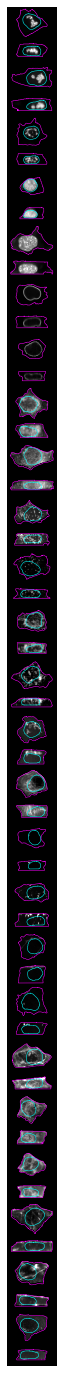

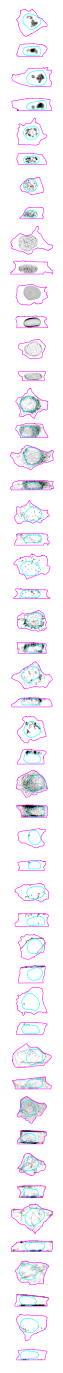

In [14]:
bbox = 400
importlib.reload(common)
common.make_contact_sheet_raw_and_seg_channels(
    data = data,
    bbox = bbox,
    file_prefix = "MovieMitotics2_gfp",
    nucleus_contour_off = ["LMNB1", "NUP153", "HIST1H2BJ"]
)

### Create domain (mean cell shape)

In [9]:
# nisos = control.get_number_of_interpolating_points()
# inner_alias = control.get_inner_most_alias_to_parameterize()
# outer_alias = control.get_outer_most_alias_to_parameterize()
# inner_mesh = device.read_vtk_polydata(f"avgshape/m2_{inner_alias}_matched.vtk")
# outer_mesh = device.read_vtk_polydata(f"avgshape/m2_{outer_alias}_matched.vtk")
# domain, origin = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])
# coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
#     seg_mem=(domain>0).astype(np.uint8),
#     seg_nuc=(domain>1).astype(np.uint8),
#     lmax=control.get_lmax(), nisos=[nisos, nisos]
# )
# coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid
# coords_param += np.array(centroid_nuc).reshape(3, 1, 1)-np.array(centroid_mem).reshape(3, 1, 1)

In [10]:
# domain_nuc = (255*(domain>1)).astype(np.uint8)
# domain_mem = (255*(domain>0)).astype(np.uint8)

### Load avg representations

In [11]:
# path_step = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance_m3/shapemode")
# control, device = common.get_managers_from_step_path(path_step)

In [12]:
# for iid in range(len(selection["FBL"])):
#     morphs = {}
#     for gene in data.keys():
#         instance = data[gene][iid]
#         rep = device.read_parameterized_intensity(instance["CellId"])
#         morphed = cytoparam.morph_representation_on_shape(
#             img=domain,
#             param_img_coords=coords_param,
#             representation=rep
#         )
#         morphed = np.stack([domain_nuc, domain_mem, morphed, morphed], axis=0)
#         morphs[gene] = [{"CelllId": instance["CellId"], "img": morphed}]
        
#     bbox = 400

#     common.make_contact_sheet_raw_and_seg_channels(
#         data = morphs,
#         bbox = bbox,
#         file_prefix = f"Movie_i2_gfp_morphed_{iid}",
#         nucleus_contour_off = ["LMNB1", "NUP153",  "HIST1H2BJ"]
#     )

In [13]:
common.now("complete")

complete 2022-06-28 01:40:53
